# Import des librairies

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from collections import Counter

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model

#Paramètres graphiques 
rcParams['figure.figsize'] = 15,8 #Taille de la figure affichée
sns.set_style("darkgrid")#style de l'arrière plan de seaborn 
sns.set_palette("pastel")#Couleurs utilisées dans les graphiques 
plt.rcParams["figure.dpi"] = 200 #dpi = dot per inch , résolution des graphiques 
pd.set_option('display.max_columns', 500) #Nombre de colonne maximum du dataframe à afficher

import warnings
warnings.simplefilter(action='ignore')

In [ ]:
def check_nan(df):
    for i in df.columns.tolist():
        print("Valeurs nan dans "+str(i)+" : "+str(df[i].isna().sum()))
        
def check_unique(df):
    for i in df.columns.tolist():
        print("Valeurs uniques dans "+str(i)+" : "+str(df[i].nunique()))
        
def data_reading(df, cols_to_list, cols_to_string, cols_to_date) :
    for col in cols_to_list : 
        df[col] = df[col].apply(lambda data : eval(str(data)) if str(data)!="nan" else [] )
        
    for col in cols_to_string : 
        df[col]= df[col].astype(str)
        
    for col in cols_to_date : 
        df[col] = pd.to_datetime(df[col])
                
    return df 

In [ ]:
def plot_history_training(history,metric_name):
    fig, axes = plt.subplots(1,2, figsize=(22,6))
    
    # Plot accuracy
    ax= axes[0]
    ax.plot(history[metric_name],'bo--', label = metric_name)
    ax.plot(history['val_'+metric_name], 'ro--', label = "val_"+metric_name)
    ax.set_title(f"Train_{metric_name} vs val_{metric_name}\n", fontsize=15)
    ax.set_ylabel(metric_name)
    ax.set_xlabel("epochs")
    ax.legend()

    # Plot loss function
    ax= axes[1]
    ax.plot(history['loss'],'bo--', label = "loss")
    ax.plot(history['val_loss'], 'ro--', label = "val_loss")
    ax.set_title("Train_loss vs val_loss\n", fontsize=15)
    ax.set_ylabel("loss")
    ax.set_xlabel("epochs")
    ax.legend()



    plt.tight_layout()
    plt.show()

# Chargement des données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path="/content/drive/MyDrive/WebScrapping/data/"
model_path="/content/drive/MyDrive/WebScrapping/model/"

In [ ]:
data= pd.read_csv(data_path+"data_brut_IA.csv",sep=";")
print("Shape dataframe :",data.shape)
check_nan(data)
print()
check_unique(data)

df = data_reading(data, cols_to_list=["genres","realisateurs","scenaristes","acteurs","pays_origine","langue_origine"],
                        cols_to_string=["titre","support"],
                        cols_to_date=["date_sortie"])

df["note_moyenne_presse"]=df["note_moyenne_presse"].astype(str).apply(lambda note : np.float64(note.replace(",",".")) if note !="nan" else np.nan)
df["note_moyenne_spectateurs_allocine"]=df["note_moyenne_spectateurs_allocine"].astype(str).apply(lambda note : np.float64(note.replace(",",".")) if note !="nan" else np.nan)

df.head(2)

Shape dataframe : (19882, 15)
Valeurs nan dans id : 0
Valeurs nan dans titre : 0
Valeurs nan dans date_sortie : 0
Valeurs nan dans support : 69
Valeurs nan dans duree : 202
Valeurs nan dans genres : 0
Valeurs nan dans realisateurs : 148
Valeurs nan dans scenaristes : 703
Valeurs nan dans acteurs : 149
Valeurs nan dans pays_origine : 2953
Valeurs nan dans langue_origine : 2953
Valeurs nan dans budget : 11504
Valeurs nan dans note_moyenne_presse : 10349
Valeurs nan dans note_moyenne_spectateurs_allocine : 113
Valeurs nan dans note_moyenne_spectateurs_sc : 2538

Valeurs uniques dans id : 19882
Valeurs uniques dans titre : 19051
Valeurs uniques dans date_sortie : 6009
Valeurs uniques dans support : 28
Valeurs uniques dans duree : 213
Valeurs uniques dans genres : 1798
Valeurs uniques dans realisateurs : 8633
Valeurs uniques dans scenaristes : 16578
Valeurs uniques dans acteurs : 19716
Valeurs uniques dans pays_origine : 2182
Valeurs uniques dans langue_origine : 2203
Valeurs uniques dans b

,id,titre,date_sortie,support,duree,genres,realisateurs,scenaristes,acteurs,pays_origine,langue_origine,budget,note_moyenne_presse,note_moyenne_spectateurs_allocine,note_moyenne_spectateurs_sc
0,178014,avatar : la voie de l'eau,2022-12-14,en salle,192.0,"[Science fiction, Aventure, Fantastique, Action]",[1066],"[49984, 1066, 1066, 49985, 49984, 49985, 77617...","[41339, 34515, 259, 6407, 12973, 22533, 130952...",[United States],[English],350000000.0,4.1,4.3,3.45
1,281293,les banshees d'inisherin,2022-12-28,en salle,114.0,[Drame],[142452],[142452],"[41623, 21353, 101150, 646346, 60312, 178500, ...","[Ireland, United Kingdom, United States]",[English],NaN,3.8,3.9,3.65


# Preprocessing

## Dates

In [ ]:
df["annee_sortie"] = df["date_sortie"].dt.year
df["mois_sortie"] = df["date_sortie"].dt.month
df["jour_semaine"] = df["date_sortie"].dt.dayofweek

## Valeurs nan

Les valeurs nan dans durée et budget ont de grandes chances de provenir de films peu connus, on suppose donc que leur budget est plutôt bas et que leur durée est classique.

In [ ]:
df["duree"]= df["duree"].fillna(df["duree"].mean())
df["budget"]=df["budget"].fillna(df["budget"].quantile(0.25))

## Embeddings

In [ ]:
df_model=df.copy(deep=True)

Colonnes pour lequelles on va réaliser des matrices d'embedding :

In [ ]:
cols_embed0 = ["acteurs","realisateurs","scenaristes"]
cols_embed1 =["genres"]
cols_embed2 =["langue_origine"]
cols_embed3 = ["pays_origine"]
cols_embed4 =["support"]
embeds = [cols_embed0, cols_embed1,cols_embed2,cols_embed3,cols_embed4]

Tokenization

In [ ]:
list_tokenizers = []
list_word_index=[]
dict_max_nb_words= {0:512,1:16,2:16,3:16,4:16 }

for i,embed in enumerate(embeds) : 
    values_to_encode=pd.concat([df_model[col].apply(lambda list_words : " ".join(list_words) if type(list_words)==list else list_words) for col in embed])
    tokenizer=tf.keras.preprocessing.text.Tokenizer(
        num_words=dict_max_nb_words[i],
        oov_token=""
    )
    tokenizer.fit_on_texts(values_to_encode)
    list_word_index.append(tokenizer.word_index)
    list_tokenizers.append(tokenizer)

In [ ]:
for i, dico in enumerate(list_word_index) : 
    print(f"Il y a {len(dico)} tokens unique dans embed {i}")

Il y a 78173 tokens unique dans embed 0
Il y a 36 tokens unique dans embed 1
Il y a 228 tokens unique dans embed 2
Il y a 181 tokens unique dans embed 3
Il y a 28 tokens unique dans embed 4


Texts to sequences

In [ ]:
for index, embed in enumerate(embeds) : 
    for col in embed : 
        df_model[col]= list_tokenizers[index].texts_to_sequences(df_model[col]) 

In [ ]:
len(set(df_model["scenaristes"].sum()+df_model["acteurs"].sum()+df_model["realisateurs"].sum()))

511

On observe qu'il y a bien moins de 512 personnes uniques qui sont encodées.

In [ ]:
df_model.head(2)

,id,titre,date_sortie,support,duree,genres,realisateurs,scenaristes,acteurs,pays_origine,langue_origine,budget,note_moyenne_presse,note_moyenne_spectateurs_allocine,note_moyenne_spectateurs_sc,annee_sortie,mois_sortie,jour_semaine
0,178014,avatar : la voie de l'eau,2022-12-14,"[2, 3]",192.0,"[1, 7, 12, 5]",[1],"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 212, 1, 438, 1, 1, 1]",[1],[2],350000000.0,4.1,4.3,3.45,2022,12,2
1,281293,les banshees d'inisherin,2022-12-28,"[2, 3]",114.0,[2],[1],[1],"[139, 180, 1, 1, 1, 1, 1, 1]","[1, 1, 1]",[2],4354110.5,3.8,3.9,3.65,2022,12,2


Padding 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LENGTH_SEQ=8

for index, embed in enumerate(embeds) : 
    for col in embed : 
        df_model[col]= list(pad_sequences(df_model[col], maxlen=MAX_LENGTH_SEQ, padding="post") )

df_model.head(4)

,id,titre,date_sortie,support,duree,genres,realisateurs,scenaristes,acteurs,pays_origine,langue_origine,budget,note_moyenne_presse,note_moyenne_spectateurs_allocine,note_moyenne_spectateurs_sc,annee_sortie,mois_sortie,jour_semaine
0,178014,avatar : la voie de l'eau,2022-12-14,"[2, 3, 0, 0, 0, 0, 0, 0]",192.0,"[1, 7, 12, 5, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 212, 1, 438, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[2, 0, 0, 0, 0, 0, 0, 0]",350000000.0,4.1,4.3,3.45,2022,12,2
1,281293,les banshees d'inisherin,2022-12-28,"[2, 3, 0, 0, 0, 0, 0, 0]",114.0,"[2, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[139, 180, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 0, 0, 0, 0, 0]","[2, 0, 0, 0, 0, 0, 0, 0]",4354110.5,3.8,3.9,3.65,2022,12,2
2,289305,tempête,2022-12-21,"[2, 3, 0, 0, 0, 0, 0, 0]",109.0,"[1, 1, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 0]","[200, 474, 1, 1, 1, 1, 1, 1]","[4, 0, 0, 0, 0, 0, 0, 0]","[3, 0, 0, 0, 0, 0, 0, 0]",12600000.0,3.0,3.9,3.10,2022,12,2
3,266320,m3gan,2022-12-28,"[2, 3, 0, 0, 0, 0, 0, 0]",102.0,"[1, 4, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0, 0, 0]","[2, 0, 0, 0, 0, 0, 0, 0]",12000000.0,2.9,2.9,2.70,2022,12,2


# Modèles 

## Notes spectateurs Allociné 

### Split train - test

In [ ]:
from sklearn.model_selection import train_test_split

df_model=df_model.dropna(subset=["note_moyenne_spectateurs_allocine"])

X = df_model[["support","duree","genres","realisateurs","scenaristes","acteurs","pays_origine","langue_origine","budget","annee_sortie","mois_sortie","jour_semaine"]]
y = df_model["note_moyenne_spectateurs_allocine"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (14826, 12)
y_train shape :  (14826,)
X_test shape :  (4943, 12)
y_test shape :  (4943,)


### Séparation embeddings

In [ ]:
embeds

[['acteurs', 'realisateurs', 'scenaristes'],
 ['genres'],
 ['langue_origine'],
 ['pays_origine'],
 ['support']]

In [ ]:
X_train.loc[:,embeds[0]]

,acteurs,realisateurs,scenaristes
96,"[140, 1, 1, 1, 1, 1, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
12448,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0, 0, 0]"
19366,"[1, 1, 1, 1, 1, 1, 1, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
5901,"[1, 1, 1, 1, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
5535,"[1, 1, 1, 1, 62, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
14837,"[1, 1, 1, 1, 1, 1, 1, 332]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
10147,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]"
9693,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]"
2583,"[1, 1, 1, 1, 1, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
X_train_e0 = X_train.loc[:,embeds[0]]
X_train_e1 = X_train.loc[:,embeds[1]]
X_train_e2 = X_train.loc[:,embeds[2]]
X_train_e3 = X_train.loc[:,embeds[3]]
X_train_e4 = X_train.loc[:,embeds[4]]
X_train_rest=X_train.drop(columns=np.sum(embeds))

X_test_e0 = X_test.loc[:,embeds[0]]
X_test_e1 = X_test.loc[:,embeds[1]]
X_test_e2 = X_test.loc[:,embeds[2]]
X_test_e3 = X_test.loc[:,embeds[3]]
X_test_e4 = X_test.loc[:,embeds[4]]
X_test_rest=X_test.drop(columns=np.sum(embeds))

In [ ]:
X_train_e0=X_train_e0.apply(lambda row : np.array(list(row.acteurs) + list(row.realisateurs) + list(row.scenaristes)) ,axis=1)

X_test_e0=X_test_e0.apply(lambda row : np.array(list(row.acteurs) + list(row.realisateurs) + list(row.scenaristes)) ,axis=1)

In [ ]:
def convert_np_array(array_init) :
    array_lists =[]
    for i in range(len(array_init)): 
        array_lists.append(list(array_init.values[i]))
    return np.array(array_lists)

X_train_e0=convert_np_array(X_train_e0).astype(float)
X_train_e1=convert_np_array(X_train_e1)
X_train_e2=convert_np_array(X_train_e2)
X_train_e3=convert_np_array(X_train_e3)
X_train_e4=convert_np_array(X_train_e4)

X_test_e0=convert_np_array(X_test_e0).astype(float)
X_test_e1=convert_np_array(X_test_e1)
X_test_e2=convert_np_array(X_test_e2)
X_test_e3=convert_np_array(X_test_e3)
X_test_e4=convert_np_array(X_test_e4)


X_train_e1=X_train_e1.reshape(X_train_e1.shape[0],X_train_e1.shape[2]).astype(float)
X_train_e2=X_train_e2.reshape(X_train_e2.shape[0],X_train_e2.shape[2]).astype(float)
X_train_e3=X_train_e3.reshape(X_train_e3.shape[0],X_train_e3.shape[2]).astype(float)
X_train_e4=X_train_e4.reshape(X_train_e4.shape[0],X_train_e4.shape[2]).astype(float)

X_test_e1=X_test_e1.reshape(X_test_e1.shape[0],X_test_e1.shape[2]).astype(float)
X_test_e2=X_test_e2.reshape(X_test_e2.shape[0],X_test_e2.shape[2]).astype(float)
X_test_e3=X_test_e3.reshape(X_test_e3.shape[0],X_test_e3.shape[2]).astype(float)
X_test_e4=X_test_e4.reshape(X_test_e4.shape[0],X_test_e4.shape[2]).astype(float)

In [ ]:
X_train_e1.shape

(14826, 8)

###Normalisation des données 

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_rest)
X_train_rest_scaled =scaler.transform(X_train_rest)
X_test_rest_scaled=scaler.transform(X_test_rest)

### Création du modèle 

In [ ]:
from tensorflow.keras.layers import Dense, Input, Embedding, BatchNormalization, Flatten, concatenate,Dropout, GlobalAveragePooling1D

#Les données sont séparées en 6 inputs
input0 = Input(shape=(24,))
input1 = Input(shape=(8,))
input2 = Input(shape=(8,))
input3 = Input(shape=(8,))
input4 = Input(shape=(8,))
input_rest = Input(shape=(X_train_rest.shape[1],))


# Embedding 0 : Acteurs, réalisateurs, scénaristes
x0 = Embedding(512 , 8)(input0)
x0=GlobalAveragePooling1D()(x0)#Flatten()(x0)
x0=Dense(8,activation="relu")(x0)
x0=BatchNormalization()(x0)
x0 = Model(inputs=input0, outputs=x0)

# Embedding 1 : #Genres 
x1 = Embedding(32 , 4)(input1)
x1=GlobalAveragePooling1D()(x1)#Flatten()(x0)
x1=Dense(8,activation="relu")(x1)
x1=BatchNormalization()(x1)
x1 = Model(inputs=input1, outputs=x1)


# Embedding 2 : #langue_origine
x2 = Embedding(16 , 2)(input2)
x2=GlobalAveragePooling1D()(x2)#Flatten()(x0)
x2=Dense(8,activation="relu")(x2)
x2=BatchNormalization()(x2)
x2 = Model(inputs=input2, outputs=x2)


# Embedding 3 : pays_origine
x3 = Embedding(16 , 2)(input3)
x3=GlobalAveragePooling1D()(x3)#Flatten()(x0)
x3=Dense(8,activation="relu")(x3)
x3=BatchNormalization()(x3)
x3 = Model(inputs=input3, outputs=x3)


# Embedding 4 : Support
x4 = Embedding(16 , 2)(input4)
x4=GlobalAveragePooling1D()(x4)#Flatten()(x0)
x4=Dense(8,activation="relu")(x4)
x4=BatchNormalization()(x4)
x4 = Model(inputs=input4, outputs=x4)

#On réuni les outputs : 
combined= concatenate([input_rest, x0.output, x1.output, x2.output , x3.output ,x4.output])


z = Dense(32 , activation="relu")(combined)
z=Dropout(0.2)(z)
z=Dense(16,activation="relu")(z)
z=Dense(1,)(z)

model = Model(inputs=[input_rest,input0,input1,input2, input3, input4], outputs=z)
model.summary()

Model: "model_126"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_139 (InputLayer)         [(None, 24)]         0           []                               
                                                                                                  
 input_140 (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 input_141 (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 input_142 (InputLayer)         [(None, 8)]          0           []                               
                                                                                          

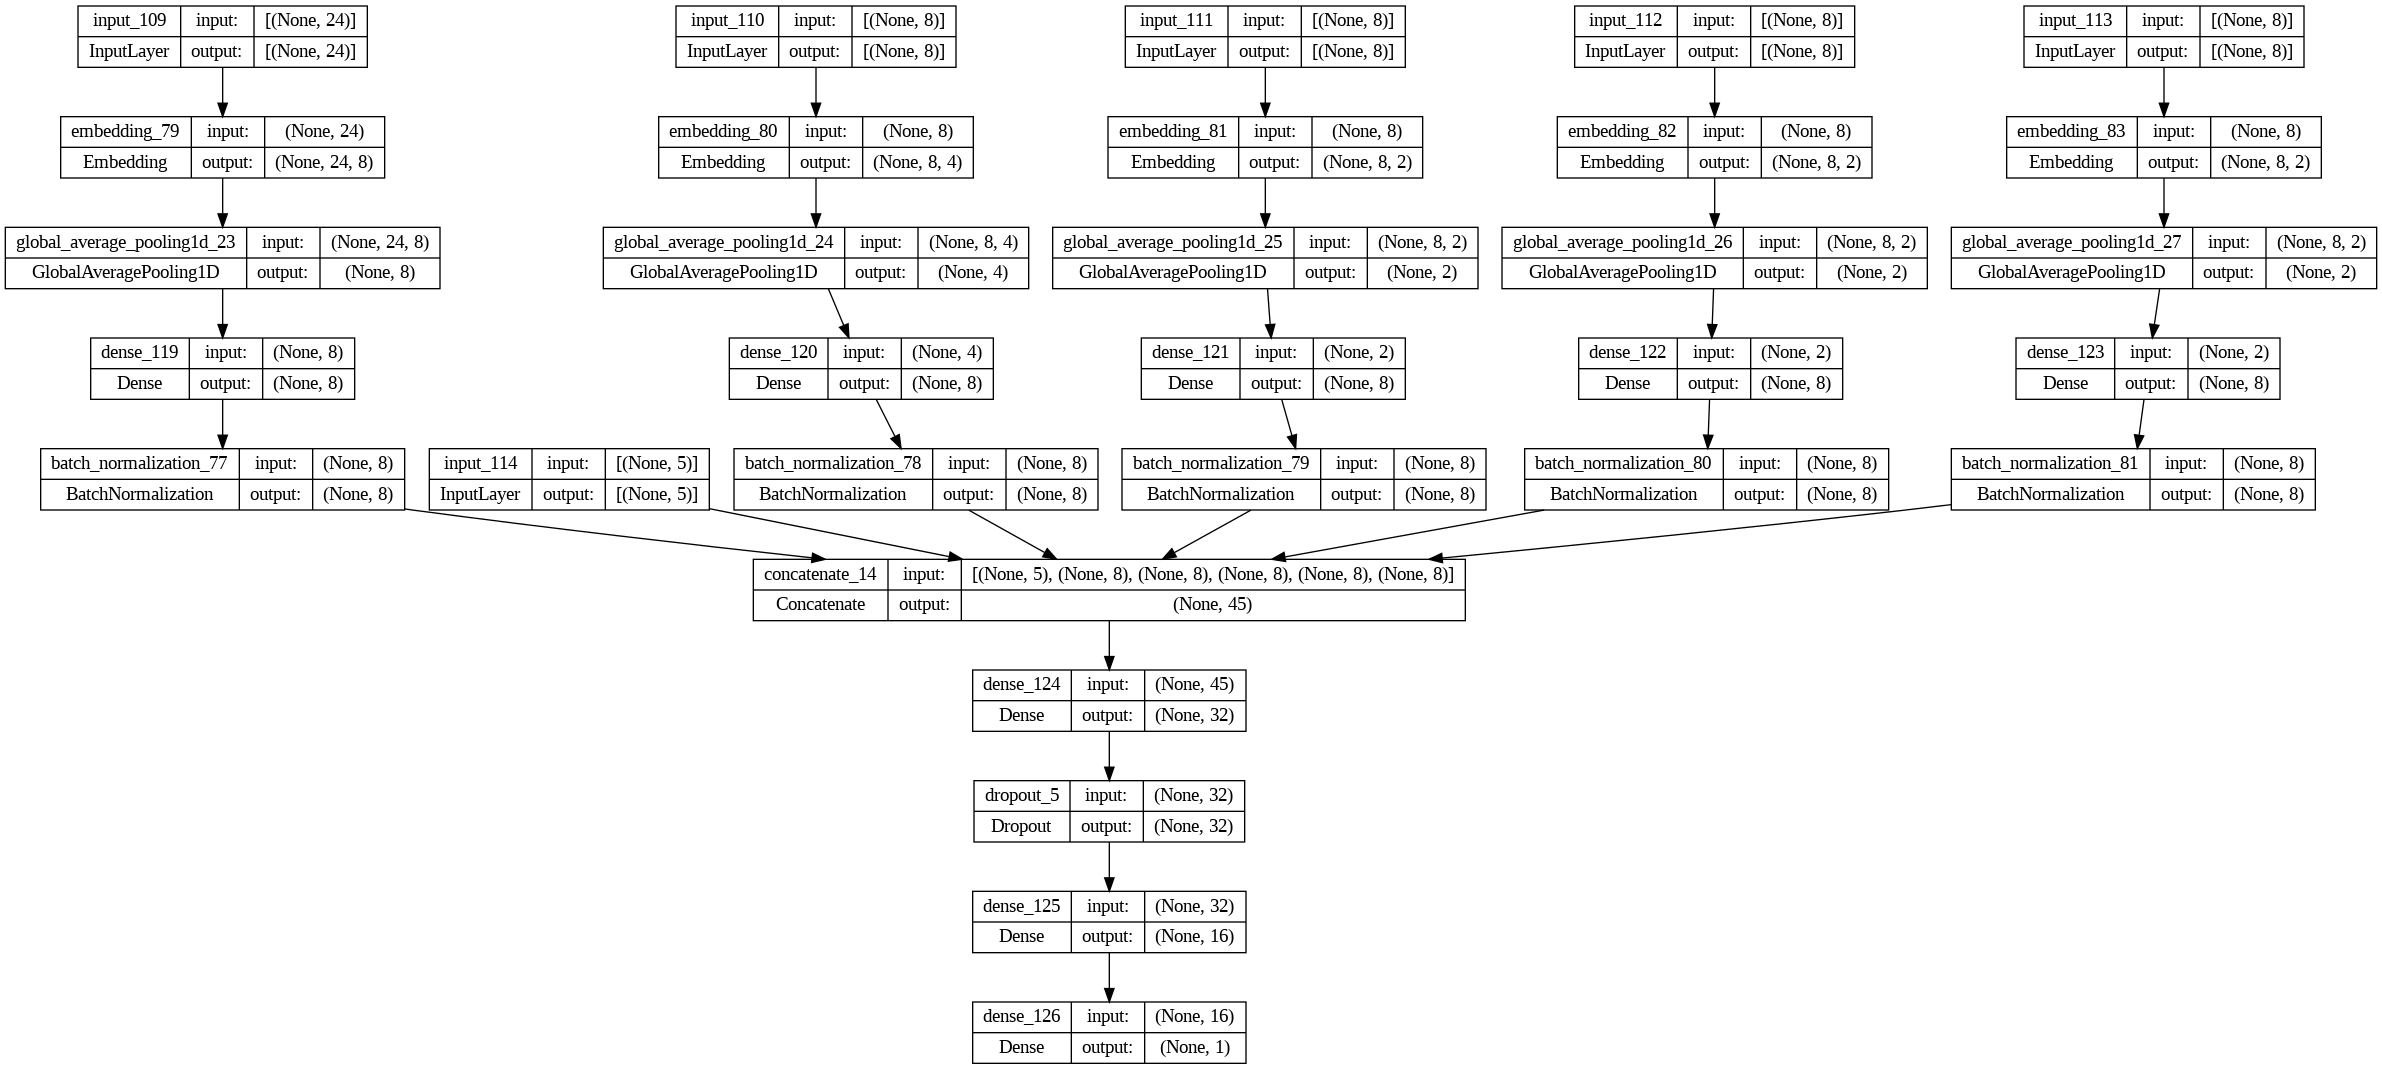

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import keras
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mae",metrics=["mse"])

checkpoint_filepath="/tmp/checkpoint"

history =model.fit(x=[X_train_rest_scaled,X_train_e0,X_train_e1,X_train_e2,X_train_e3,X_train_e4],y=y_train,
                   validation_data=([X_test_rest_scaled,X_test_e0,X_test_e1,X_test_e2,X_test_e3,X_test_e4],y_test),
                    epochs =80,batch_size=128,
                  callbacks =[
                              tf.keras.callbacks.EarlyStopping(
                                  monitor="val_loss", patience=10, restore_best_weights=True),
                             tf.keras.callbacks.ModelCheckpoint(
                                 filepath = checkpoint_filepath , 
                                 save_weights_only=True, 
                                 monitor="val_loss",
                                 mode="max",
                                 save_best_only=True)
                          ])

Epoch 1/80
116/116 [==============================] - 3s 9ms/step - loss: 2.8695 - mse: 8.7674 - val_loss: 2.7333 - val_mse: 7.9781
Epoch 2/80
116/116 [==============================] - 1s 5ms/step - loss: 2.4972 - mse: 6.8030 - val_loss: 2.3632 - val_mse: 6.1008
Epoch 3/80
116/116 [==============================] - 1s 6ms/step - loss: 1.8563 - mse: 4.1180 - val_loss: 1.6548 - val_mse: 3.2525
Epoch 4/80
116/116 [==============================] - 1s 5ms/step - loss: 1.1016 - mse: 1.7426 - val_loss: 0.7748 - val_mse: 0.8567
Epoch 5/80
116/116 [==============================] - 1s 6ms/step - loss: 0.7689 - mse: 0.9213 - val_loss: 0.5910 - val_mse: 0.5181
Epoch 6/80
116/116 [==============================] - 1s 6ms/step - loss: 0.6878 - mse: 0.7289 - val_loss: 0.5700 - val_mse: 0.4844
Epoch 7/80
116/116 [==============================] - 1s 6ms/step - loss: 0.6584 - mse: 0.6659 - val_loss: 0.5638 - val_mse: 0.4768
Epoch 8/80
116/116 [==============================] - 1s 6ms/step - loss: 0.

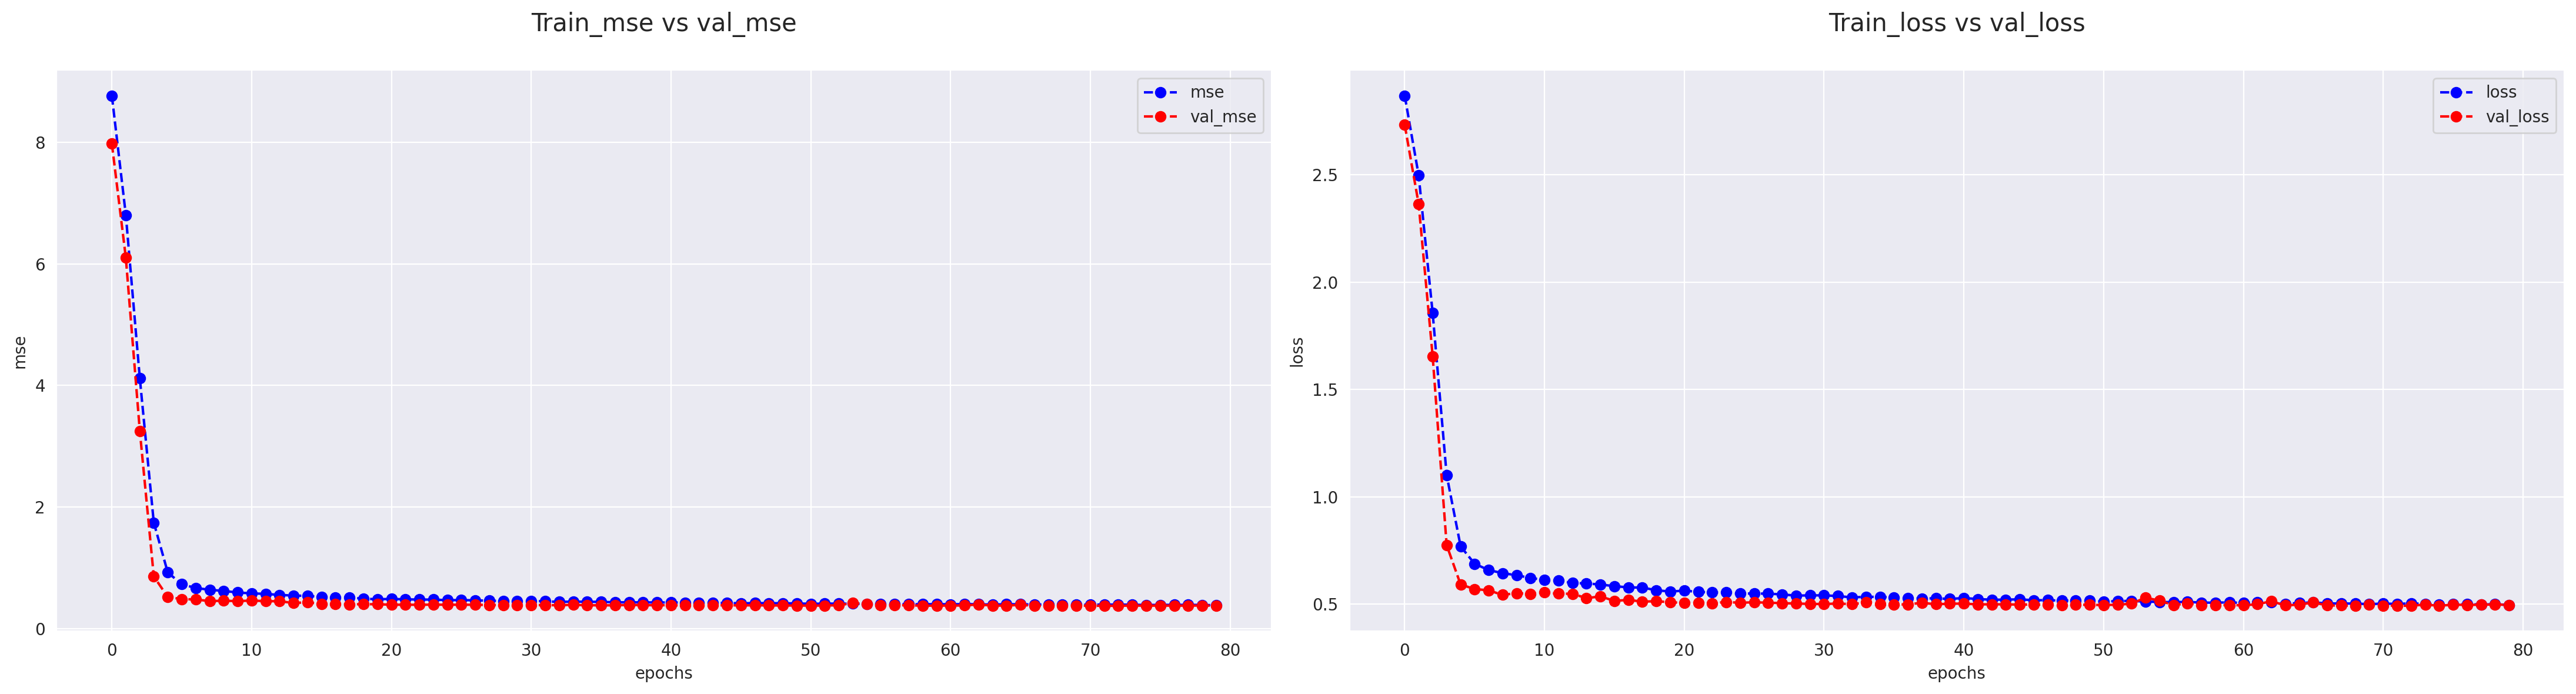

In [ ]:
plot_history_training(history.history,"mse")

In [ ]:
model.save(model_path+"note_moyenne_specs_allocine.h5")

## Notes presse  

### Split train - test

In [ ]:
df_model.head()

,id,titre,date_sortie,support,duree,genres,realisateurs,scenaristes,acteurs,pays_origine,langue_origine,budget,note_moyenne_presse,note_moyenne_spectateurs_allocine,annee_sortie,mois_sortie,jour_semaine
0,178014,avatar : la voie de l'eau,2022-12-14,"[2, 3, 0, 0, 0, 0, 0, 0]",192.0,"[1, 7, 12, 5, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 212, 1, 438, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[2, 0, 0, 0, 0, 0, 0, 0]",350000000.0,4.1,4.3,2022,12,2
1,281293,les banshees d'inisherin,2022-12-28,"[2, 3, 0, 0, 0, 0, 0, 0]",114.0,"[2, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[139, 180, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 0, 0, 0, 0, 0]","[2, 0, 0, 0, 0, 0, 0, 0]",4354110.5,3.8,3.9,2022,12,2
2,289305,tempête,2022-12-21,"[2, 3, 0, 0, 0, 0, 0, 0]",109.0,"[1, 1, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 0]","[200, 474, 1, 1, 1, 1, 1, 1]","[4, 0, 0, 0, 0, 0, 0, 0]","[3, 0, 0, 0, 0, 0, 0, 0]",12600000.0,3.0,3.9,2022,12,2
3,266320,m3gan,2022-12-28,"[2, 3, 0, 0, 0, 0, 0, 0]",102.0,"[1, 4, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0, 0, 0]","[2, 0, 0, 0, 0, 0, 0, 0]",12000000.0,2.9,2.9,2022,12,2
4,288544,le tourbillon de la vie,2022-12-21,"[2, 3, 0, 0, 0, 0, 0, 0]",121.0,"[2, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]","[1, 1, 81, 406, 1, 1, 32, 1]","[4, 0, 0, 0, 0, 0, 0, 0]","[3, 0, 0, 0, 0, 0, 0, 0]",4354110.5,3.3,3.9,2022,12,2


In [ ]:
from sklearn.model_selection import train_test_split

df_model=df_model.dropna(subset=["note_moyenne_presse"])

X = df_model[["support","duree","genres","realisateurs","scenaristes","acteurs","pays_origine","langue_origine","budget","annee_sortie","mois_sortie","jour_semaine"]]
y = df_model["note_moyenne_presse"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (7625, 12)
y_train shape :  (7625,)
X_test shape :  (1907, 12)
y_test shape :  (1907,)


### Séparation embeddings

In [ ]:
embeds

[['acteurs', 'realisateurs', 'scenaristes'],
 ['genres'],
 ['langue_origine'],
 ['pays_origine'],
 ['support']]

In [ ]:
X_train.loc[:,embeds[0]]

,acteurs,realisateurs,scenaristes
2744,"[1, 1, 1, 1, 1, 1, 1, 1]","[503, 0, 0, 0, 0, 0, 0, 0]","[503, 1, 0, 0, 0, 0, 0, 0]"
8602,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
19599,"[433, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
137,"[306, 380, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0, 0, 0]"
19244,"[1, 1, 1, 1, 63, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
...,...,...,...
6564,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
7049,"[484, 1, 1, 1, 497, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
14225,"[202, 52, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]"
8406,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
X_train_e0 = X_train.loc[:,embeds[0]]
X_train_e1 = X_train.loc[:,embeds[1]]
X_train_e2 = X_train.loc[:,embeds[2]]
X_train_e3 = X_train.loc[:,embeds[3]]
X_train_e4 = X_train.loc[:,embeds[4]]
X_train_rest=X_train.drop(columns=np.sum(embeds))

X_test_e0 = X_test.loc[:,embeds[0]]
X_test_e1 = X_test.loc[:,embeds[1]]
X_test_e2 = X_test.loc[:,embeds[2]]
X_test_e3 = X_test.loc[:,embeds[3]]
X_test_e4 = X_test.loc[:,embeds[4]]
X_test_rest=X_test.drop(columns=np.sum(embeds))

In [ ]:
X_train_e0=X_train_e0.apply(lambda row : np.array(list(row.acteurs) + list(row.realisateurs) + list(row.scenaristes)) ,axis=1)

X_test_e0=X_test_e0.apply(lambda row : np.array(list(row.acteurs) + list(row.realisateurs) + list(row.scenaristes)) ,axis=1)

In [ ]:
def convert_np_array(array_init) :
    array_lists =[]
    for i in range(len(array_init)): 
        array_lists.append(list(array_init.values[i]))
    return np.array(array_lists)

X_train_e0=convert_np_array(X_train_e0).astype(float)
X_train_e1=convert_np_array(X_train_e1)
X_train_e2=convert_np_array(X_train_e2)
X_train_e3=convert_np_array(X_train_e3)
X_train_e4=convert_np_array(X_train_e4)

X_test_e0=convert_np_array(X_test_e0).astype(float)
X_test_e1=convert_np_array(X_test_e1)
X_test_e2=convert_np_array(X_test_e2)
X_test_e3=convert_np_array(X_test_e3)
X_test_e4=convert_np_array(X_test_e4)


X_train_e1=X_train_e1.reshape(X_train_e1.shape[0],X_train_e1.shape[2]).astype(float)
X_train_e2=X_train_e2.reshape(X_train_e2.shape[0],X_train_e2.shape[2]).astype(float)
X_train_e3=X_train_e3.reshape(X_train_e3.shape[0],X_train_e3.shape[2]).astype(float)
X_train_e4=X_train_e4.reshape(X_train_e4.shape[0],X_train_e4.shape[2]).astype(float)

X_test_e1=X_test_e1.reshape(X_test_e1.shape[0],X_test_e1.shape[2]).astype(float)
X_test_e2=X_test_e2.reshape(X_test_e2.shape[0],X_test_e2.shape[2]).astype(float)
X_test_e3=X_test_e3.reshape(X_test_e3.shape[0],X_test_e3.shape[2]).astype(float)
X_test_e4=X_test_e4.reshape(X_test_e4.shape[0],X_test_e4.shape[2]).astype(float)

In [ ]:
X_train_e1.shape

(7625, 8)

###Normalisation des données 

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_rest)
X_train_rest_scaled =scaler.transform(X_train_rest)
X_test_rest_scaled=scaler.transform(X_test_rest)

### Création du modèle 

In [ ]:
from tensorflow.keras.layers import Dense, Input, Embedding, BatchNormalization, Flatten, concatenate,Dropout, GlobalAveragePooling1D

#Les données sont séparées en 6 inputs
input0 = Input(shape=(24,))
input1 = Input(shape=(8,))
input2 = Input(shape=(8,))
input3 = Input(shape=(8,))
input4 = Input(shape=(8,))
input_rest = Input(shape=(X_train_rest.shape[1],))


# Embedding 0 : Acteurs, réalisateurs, scénaristes
x0 = Embedding(512 , 8)(input0)
x0=GlobalAveragePooling1D()(x0)#Flatten()(x0)
x0=Dense(8,activation="relu")(x0)
x0=BatchNormalization()(x0)
x0 = Model(inputs=input0, outputs=x0)

# Embedding 1 : #Genres 
x1 = Embedding(32 , 4)(input1)
x1=GlobalAveragePooling1D()(x1)#Flatten()(x0)
x1=Dense(8,activation="relu")(x1)
x1=BatchNormalization()(x1)
x1 = Model(inputs=input1, outputs=x1)


# Embedding 2 : #langue_origine
x2 = Embedding(16 , 2)(input2)
x2=GlobalAveragePooling1D()(x2)#Flatten()(x0)
x2=Dense(8,activation="relu")(x2)
x2=BatchNormalization()(x2)
x2 = Model(inputs=input2, outputs=x2)


# Embedding 3 : pays_origine
x3 = Embedding(16 , 2)(input3)
x3=GlobalAveragePooling1D()(x3)#Flatten()(x0)
x3=Dense(8,activation="relu")(x3)
x3=BatchNormalization()(x3)
x3 = Model(inputs=input3, outputs=x3)


# Embedding 4 : Support
x4 = Embedding(16 , 2)(input4)
x4=GlobalAveragePooling1D()(x4)#Flatten()(x0)
x4=Dense(8,activation="relu")(x4)
x4=BatchNormalization()(x4)
x4 = Model(inputs=input4, outputs=x4)

#On réuni les outputs : 
combined= concatenate([input_rest, x0.output, x1.output, x2.output , x3.output ,x4.output])


z = Dense(16 , activation="relu")(combined)
z=Dropout(0.2)(z)
z=Dense(8,activation="relu")(z)
z=Dense(1,)(z)

model = Model(inputs=[input_rest,input0,input1,input2, input3, input4], outputs=z)
model.summary()

Model: "model_120"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_133 (InputLayer)         [(None, 24)]         0           []                               
                                                                                                  
 input_134 (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 input_135 (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 input_136 (InputLayer)         [(None, 8)]          0           []                               
                                                                                          

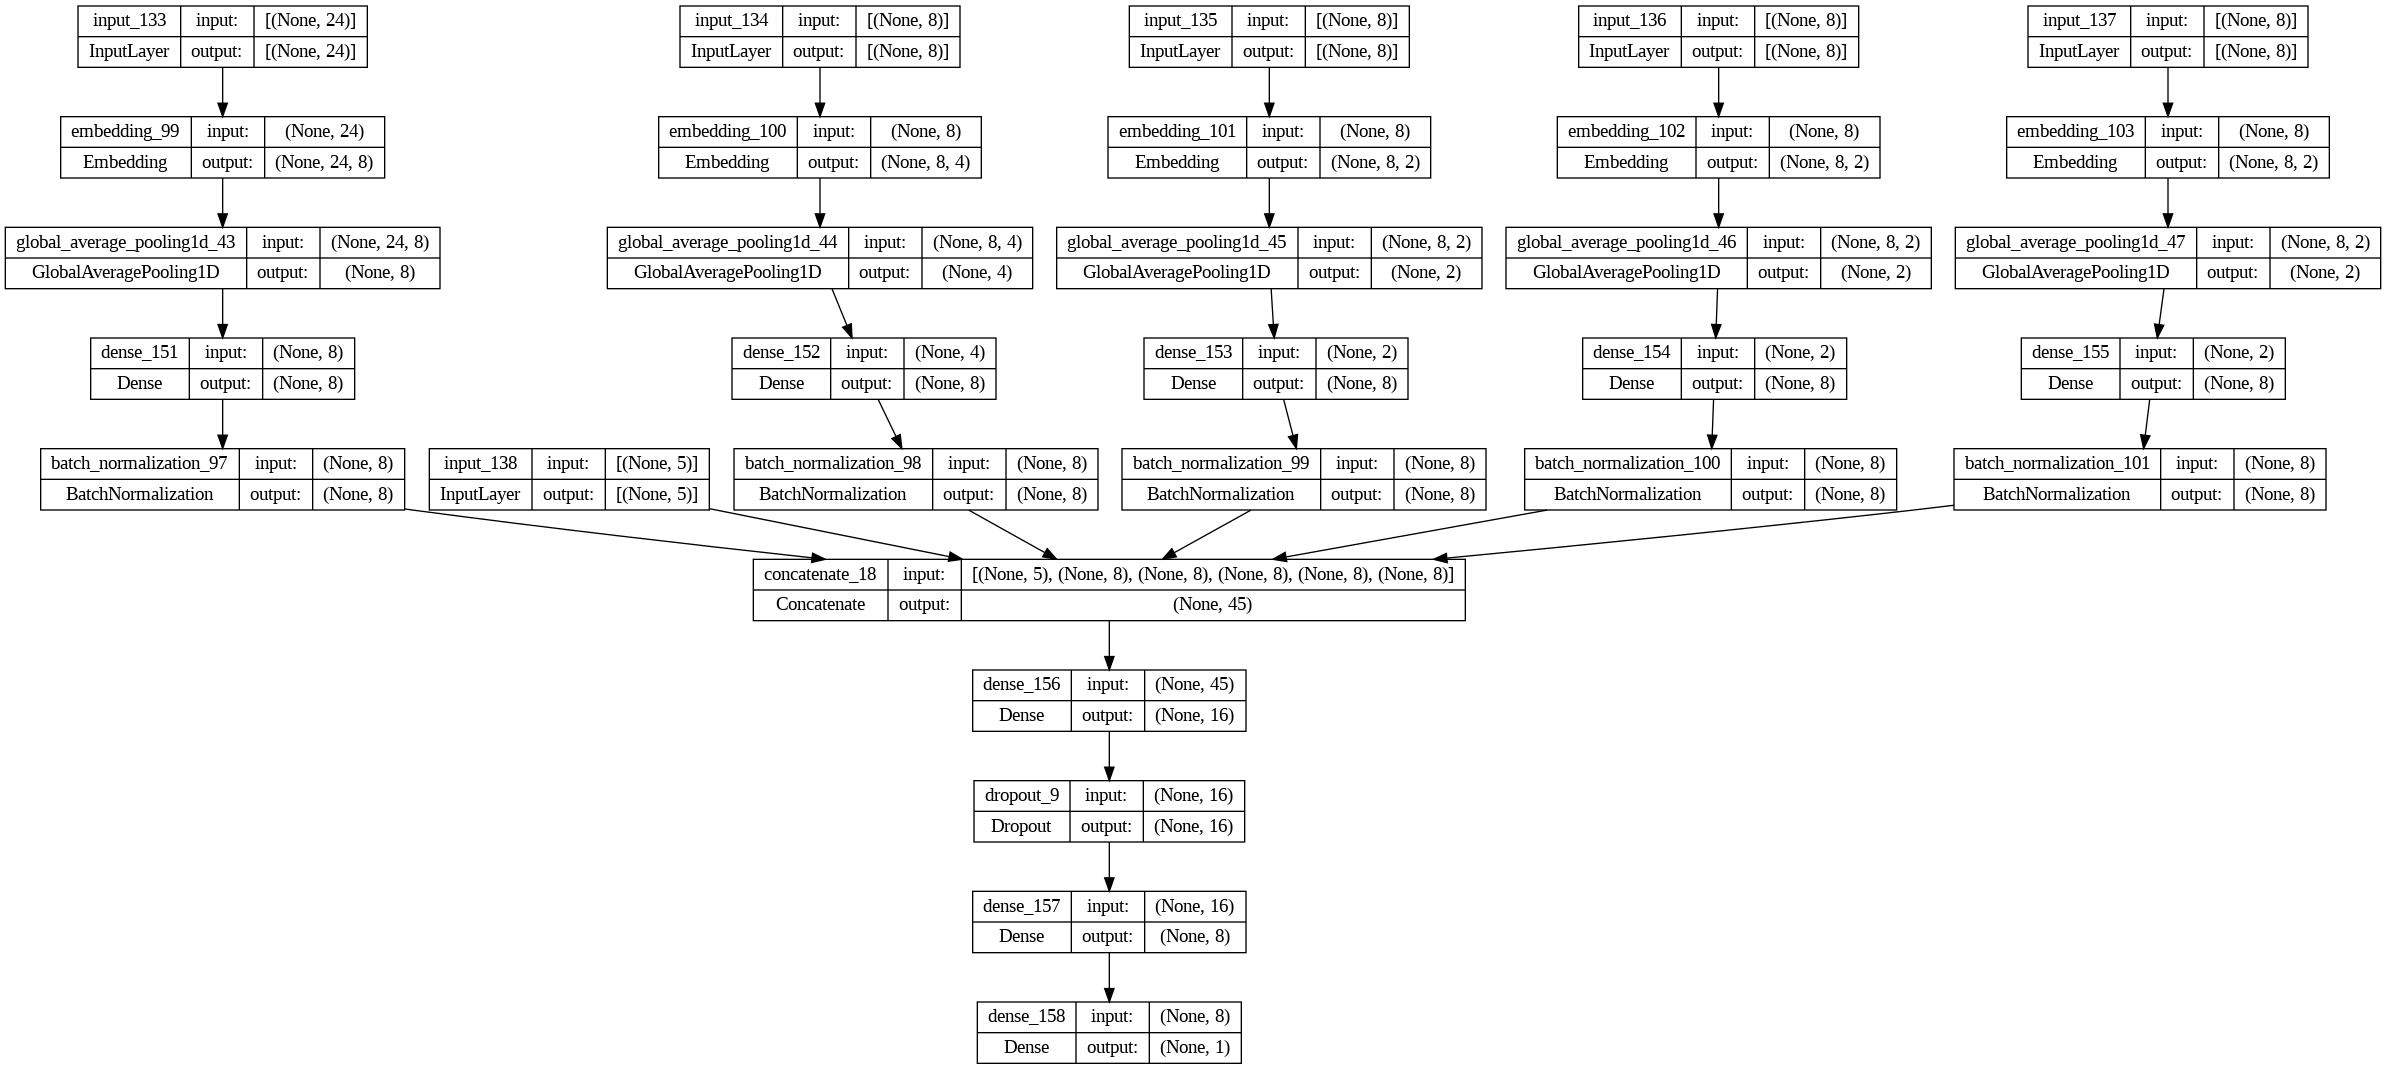

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import keras
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mae",metrics=["mse"])

checkpoint_filepath="/tmp/checkpoint"

history =model.fit(x=[X_train_rest_scaled,X_train_e0,X_train_e1,X_train_e2,X_train_e3,X_train_e4],y=y_train,
                   validation_data=([X_test_rest_scaled,X_test_e0,X_test_e1,X_test_e2,X_test_e3,X_test_e4],y_test),
                    epochs =200,batch_size=64,
                  callbacks =[
                              tf.keras.callbacks.EarlyStopping(
                                  monitor="val_loss", patience=20, restore_best_weights=True),
                             tf.keras.callbacks.ModelCheckpoint(
                                 filepath = checkpoint_filepath , 
                                 save_weights_only=True, 
                                 monitor="val_loss",
                                 mode="max",
                                 save_best_only=True)
                          ])

Epoch 1/200
120/120 [==============================] - 3s 8ms/step - loss: 2.6221 - mse: 7.5347 - val_loss: 2.4670 - val_mse: 6.6653
Epoch 2/200
120/120 [==============================] - 1s 5ms/step - loss: 2.2344 - mse: 5.7104 - val_loss: 2.0291 - val_mse: 4.7055
Epoch 3/200
120/120 [==============================] - 1s 5ms/step - loss: 1.6910 - mse: 3.6159 - val_loss: 1.3412 - val_mse: 2.3459
Epoch 4/200
120/120 [==============================] - 1s 5ms/step - loss: 1.0957 - mse: 1.8308 - val_loss: 0.7332 - val_mse: 0.8915
Epoch 5/200
120/120 [==============================] - 1s 5ms/step - loss: 0.8220 - mse: 1.1240 - val_loss: 0.5984 - val_mse: 0.6263
Epoch 6/200
120/120 [==============================] - 1s 5ms/step - loss: 0.7882 - mse: 1.0317 - val_loss: 0.5841 - val_mse: 0.5964
Epoch 7/200
120/120 [==============================] - 1s 5ms/step - loss: 0.7718 - mse: 0.9760 - val_loss: 0.5882 - val_mse: 0.6024
Epoch 8/200
120/120 [==============================] - 1s 5ms/step - 

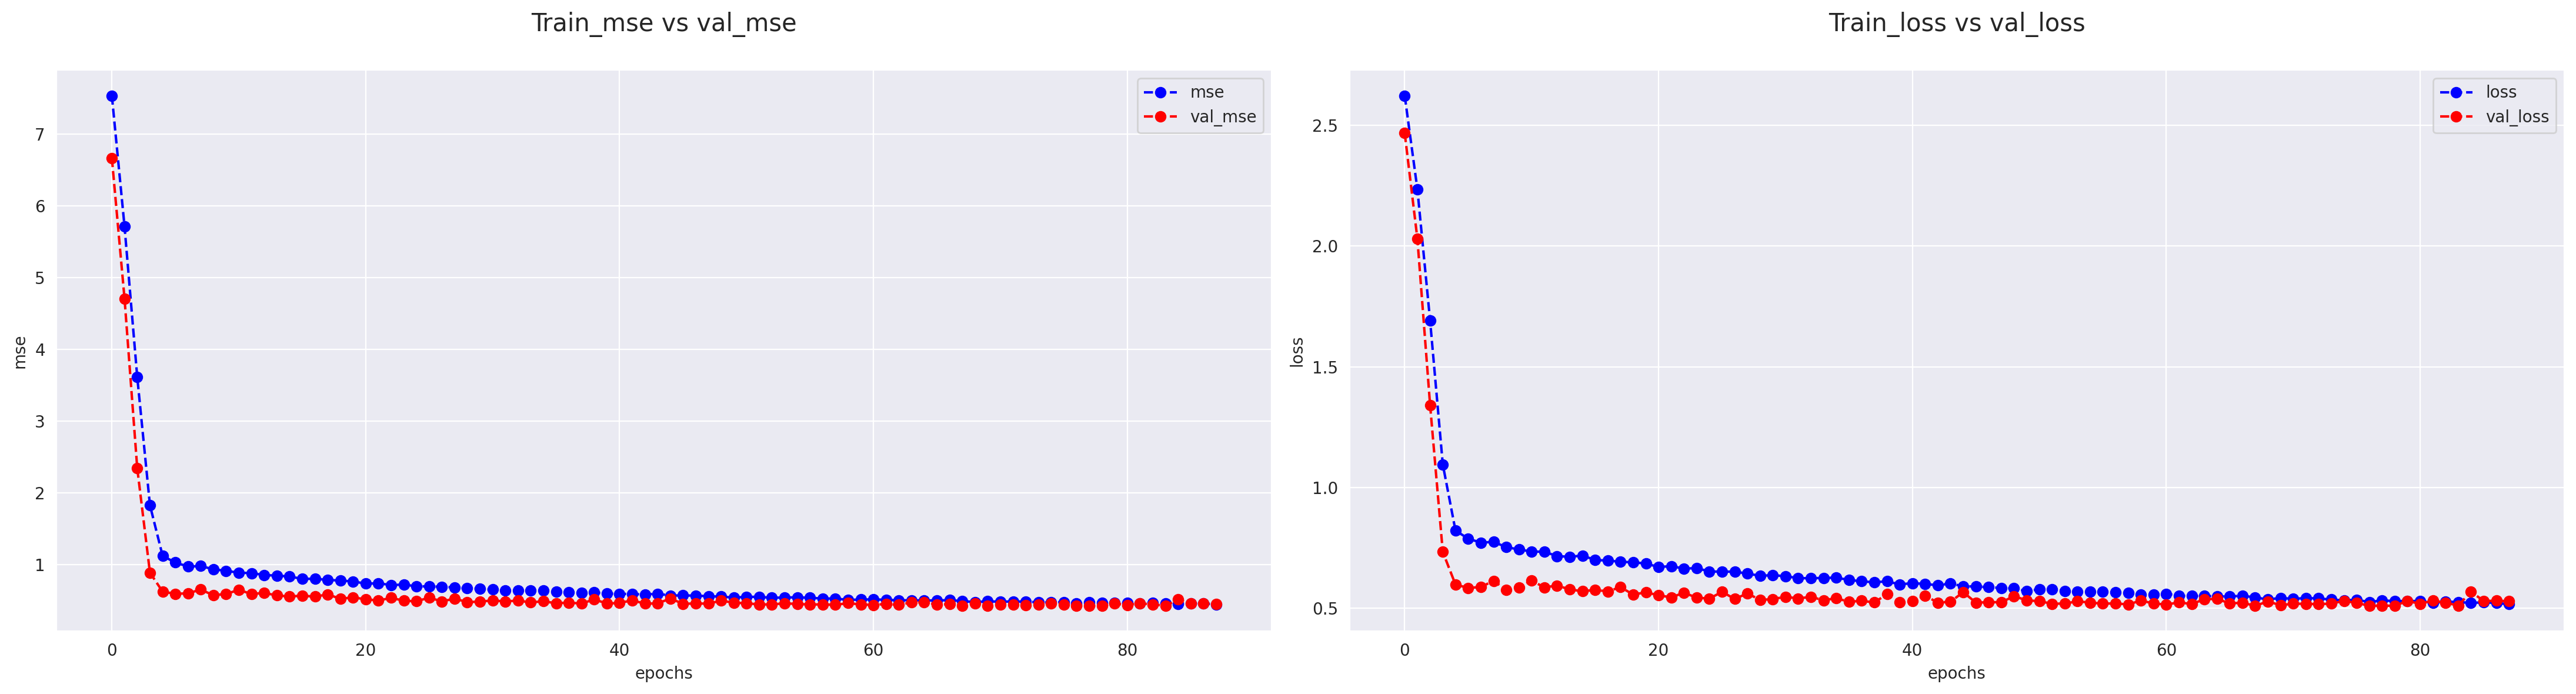

In [ ]:
plot_history_training(history.history,"mse")

In [ ]:
model.save(model_path+"note_moyenne_presse.h5")

## Notes spectateurs SensCritique  

### Split train - test

In [ ]:
from sklearn.model_selection import train_test_split

df_model=df_model.dropna(subset=["note_moyenne_spectateurs_sc"])

X = df_model[["support","duree","genres","realisateurs","scenaristes","acteurs","pays_origine","langue_origine","budget","annee_sortie","mois_sortie","jour_semaine"]]
y = df_model["note_moyenne_spectateurs_sc"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (13875, 12)
y_train shape :  (13875,)
X_test shape :  (3469, 12)
y_test shape :  (3469,)


### Séparation embeddings

In [ ]:
embeds

[['acteurs', 'realisateurs', 'scenaristes'],
 ['genres'],
 ['langue_origine'],
 ['pays_origine'],
 ['support']]

In [ ]:
X_train.loc[:,embeds[0]]

,acteurs,realisateurs,scenaristes
8789,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]"
14152,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
18310,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"
9383,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0, 0, 0]"
14409,"[335, 1, 194, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
7369,"[1, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0, 0, 0]"
3770,"[42, 103, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]"
17135,"[170, 1, 1, 1, 1, 1, 1, 1]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]"
13034,"[1, 1, 1, 1, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
X_train_e0 = X_train.loc[:,embeds[0]]
X_train_e1 = X_train.loc[:,embeds[1]]
X_train_e2 = X_train.loc[:,embeds[2]]
X_train_e3 = X_train.loc[:,embeds[3]]
X_train_e4 = X_train.loc[:,embeds[4]]
X_train_rest=X_train.drop(columns=np.sum(embeds))

X_test_e0 = X_test.loc[:,embeds[0]]
X_test_e1 = X_test.loc[:,embeds[1]]
X_test_e2 = X_test.loc[:,embeds[2]]
X_test_e3 = X_test.loc[:,embeds[3]]
X_test_e4 = X_test.loc[:,embeds[4]]
X_test_rest=X_test.drop(columns=np.sum(embeds))

In [ ]:
X_train_e0=X_train_e0.apply(lambda row : np.array(list(row.acteurs) + list(row.realisateurs) + list(row.scenaristes)) ,axis=1)

X_test_e0=X_test_e0.apply(lambda row : np.array(list(row.acteurs) + list(row.realisateurs) + list(row.scenaristes)) ,axis=1)

In [ ]:
def convert_np_array(array_init) :
    array_lists =[]
    for i in range(len(array_init)): 
        array_lists.append(list(array_init.values[i]))
    return np.array(array_lists)

X_train_e0=convert_np_array(X_train_e0).astype(float)
X_train_e1=convert_np_array(X_train_e1)
X_train_e2=convert_np_array(X_train_e2)
X_train_e3=convert_np_array(X_train_e3)
X_train_e4=convert_np_array(X_train_e4)

X_test_e0=convert_np_array(X_test_e0).astype(float)
X_test_e1=convert_np_array(X_test_e1)
X_test_e2=convert_np_array(X_test_e2)
X_test_e3=convert_np_array(X_test_e3)
X_test_e4=convert_np_array(X_test_e4)


X_train_e1=X_train_e1.reshape(X_train_e1.shape[0],X_train_e1.shape[2]).astype(float)
X_train_e2=X_train_e2.reshape(X_train_e2.shape[0],X_train_e2.shape[2]).astype(float)
X_train_e3=X_train_e3.reshape(X_train_e3.shape[0],X_train_e3.shape[2]).astype(float)
X_train_e4=X_train_e4.reshape(X_train_e4.shape[0],X_train_e4.shape[2]).astype(float)

X_test_e1=X_test_e1.reshape(X_test_e1.shape[0],X_test_e1.shape[2]).astype(float)
X_test_e2=X_test_e2.reshape(X_test_e2.shape[0],X_test_e2.shape[2]).astype(float)
X_test_e3=X_test_e3.reshape(X_test_e3.shape[0],X_test_e3.shape[2]).astype(float)
X_test_e4=X_test_e4.reshape(X_test_e4.shape[0],X_test_e4.shape[2]).astype(float)

In [ ]:
X_train_e1.shape

(13875, 8)

###Normalisation des données 

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_rest)
X_train_rest_scaled =scaler.transform(X_train_rest)
X_test_rest_scaled=scaler.transform(X_test_rest)

### Création du modèle 

In [ ]:
from tensorflow.keras.layers import Dense, Input, Embedding, BatchNormalization, Flatten, concatenate,Dropout, GlobalAveragePooling1D

#Les données sont séparées en 6 inputs
input0 = Input(shape=(24,))
input1 = Input(shape=(8,))
input2 = Input(shape=(8,))
input3 = Input(shape=(8,))
input4 = Input(shape=(8,))
input_rest = Input(shape=(X_train_rest.shape[1],))


# Embedding 0 : Acteurs, réalisateurs, scénaristes
x0 = Embedding(512 , 8)(input0)
x0=GlobalAveragePooling1D()(x0)#Flatten()(x0)
x0=Dense(8,activation="relu")(x0)
x0=BatchNormalization()(x0)
x0 = Model(inputs=input0, outputs=x0)

# Embedding 1 : #Genres 
x1 = Embedding(32 , 4)(input1)
x1=GlobalAveragePooling1D()(x1)#Flatten()(x0)
x1=Dense(8,activation="relu")(x1)
x1=BatchNormalization()(x1)
x1 = Model(inputs=input1, outputs=x1)


# Embedding 2 : #langue_origine
x2 = Embedding(16 , 2)(input2)
x2=GlobalAveragePooling1D()(x2)#Flatten()(x0)
x2=Dense(8,activation="relu")(x2)
x2=BatchNormalization()(x2)
x2 = Model(inputs=input2, outputs=x2)


# Embedding 3 : pays_origine
x3 = Embedding(16 , 2)(input3)
x3=GlobalAveragePooling1D()(x3)#Flatten()(x0)
x3=Dense(8,activation="relu")(x3)
x3=BatchNormalization()(x3)
x3 = Model(inputs=input3, outputs=x3)


# Embedding 4 : Support
x4 = Embedding(16 , 2)(input4)
x4=GlobalAveragePooling1D()(x4)#Flatten()(x0)
x4=Dense(8,activation="relu")(x4)
x4=BatchNormalization()(x4)
x4 = Model(inputs=input4, outputs=x4)

#On réuni les outputs : 
combined= concatenate([input_rest, x0.output, x1.output, x2.output , x3.output ,x4.output])


z = Dense(16 , activation="relu")(combined)
z=Dropout(0.2)(z)
z=Dense(8,activation="relu")(z)
z=Dense(1,)(z)

model = Model(inputs=[input_rest,input0,input1,input2, input3, input4], outputs=z)
model.summary()

Model: "model_132"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_145 (InputLayer)         [(None, 24)]         0           []                               
                                                                                                  
 input_146 (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 input_147 (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 input_148 (InputLayer)         [(None, 8)]          0           []                               
                                                                                          

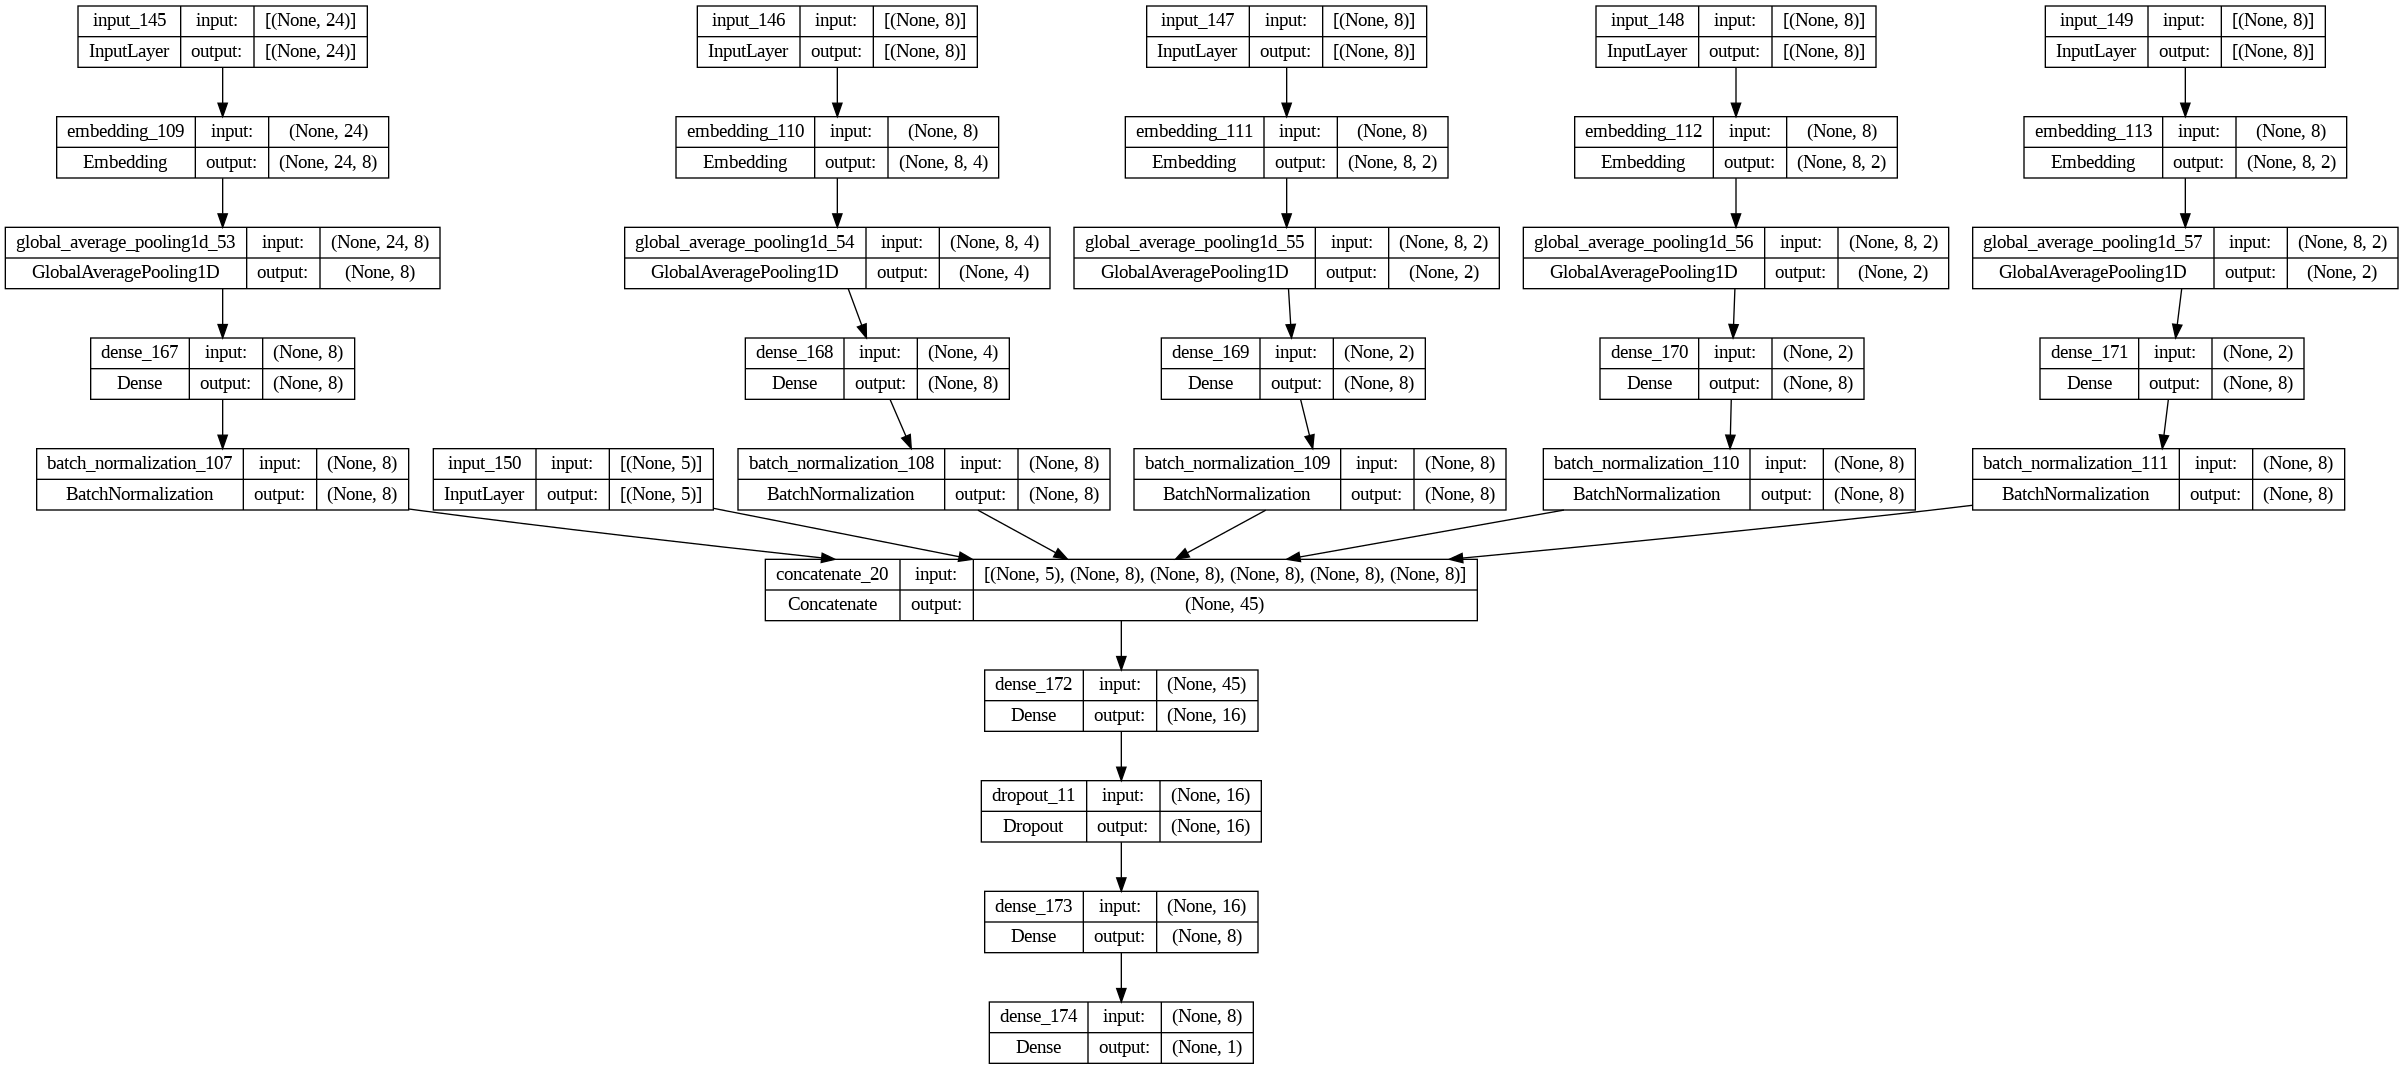

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import keras
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mae",metrics=["mse"])

checkpoint_filepath="/tmp/checkpoint"

history =model.fit(x=[X_train_rest_scaled,X_train_e0,X_train_e1,X_train_e2,X_train_e3,X_train_e4],y=y_train,
                   validation_data=([X_test_rest_scaled,X_test_e0,X_test_e1,X_test_e2,X_test_e3,X_test_e4],y_test),
                    epochs =200,batch_size=64,
                  callbacks =[
                              tf.keras.callbacks.EarlyStopping(
                                  monitor="val_loss", patience=7, restore_best_weights=True),
                             tf.keras.callbacks.ModelCheckpoint(
                                 filepath = checkpoint_filepath , 
                                 save_weights_only=True, 
                                 monitor="val_loss",
                                 mode="max",
                                 save_best_only=True)
                          ])

Epoch 1/200
217/217 [==============================] - 4s 6ms/step - loss: 2.9572 - mse: 9.0552 - val_loss: 2.8027 - val_mse: 8.1692
Epoch 2/200
217/217 [==============================] - 1s 5ms/step - loss: 2.6866 - mse: 7.5391 - val_loss: 2.4872 - val_mse: 6.5044
Epoch 3/200
217/217 [==============================] - 1s 5ms/step - loss: 2.1199 - mse: 4.8963 - val_loss: 1.5704 - val_mse: 2.7797
Epoch 4/200
217/217 [==============================] - 1s 4ms/step - loss: 0.9896 - mse: 1.3840 - val_loss: 0.4828 - val_mse: 0.3491
Epoch 5/200
217/217 [==============================] - 1s 5ms/step - loss: 0.5813 - mse: 0.5359 - val_loss: 0.4114 - val_mse: 0.2633
Epoch 6/200
217/217 [==============================] - 1s 5ms/step - loss: 0.5614 - mse: 0.5012 - val_loss: 0.3964 - val_mse: 0.2478
Epoch 7/200
217/217 [==============================] - 1s 4ms/step - loss: 0.5470 - mse: 0.4719 - val_loss: 0.3860 - val_mse: 0.2393
Epoch 8/200
217/217 [==============================] - 1s 5ms/step - 

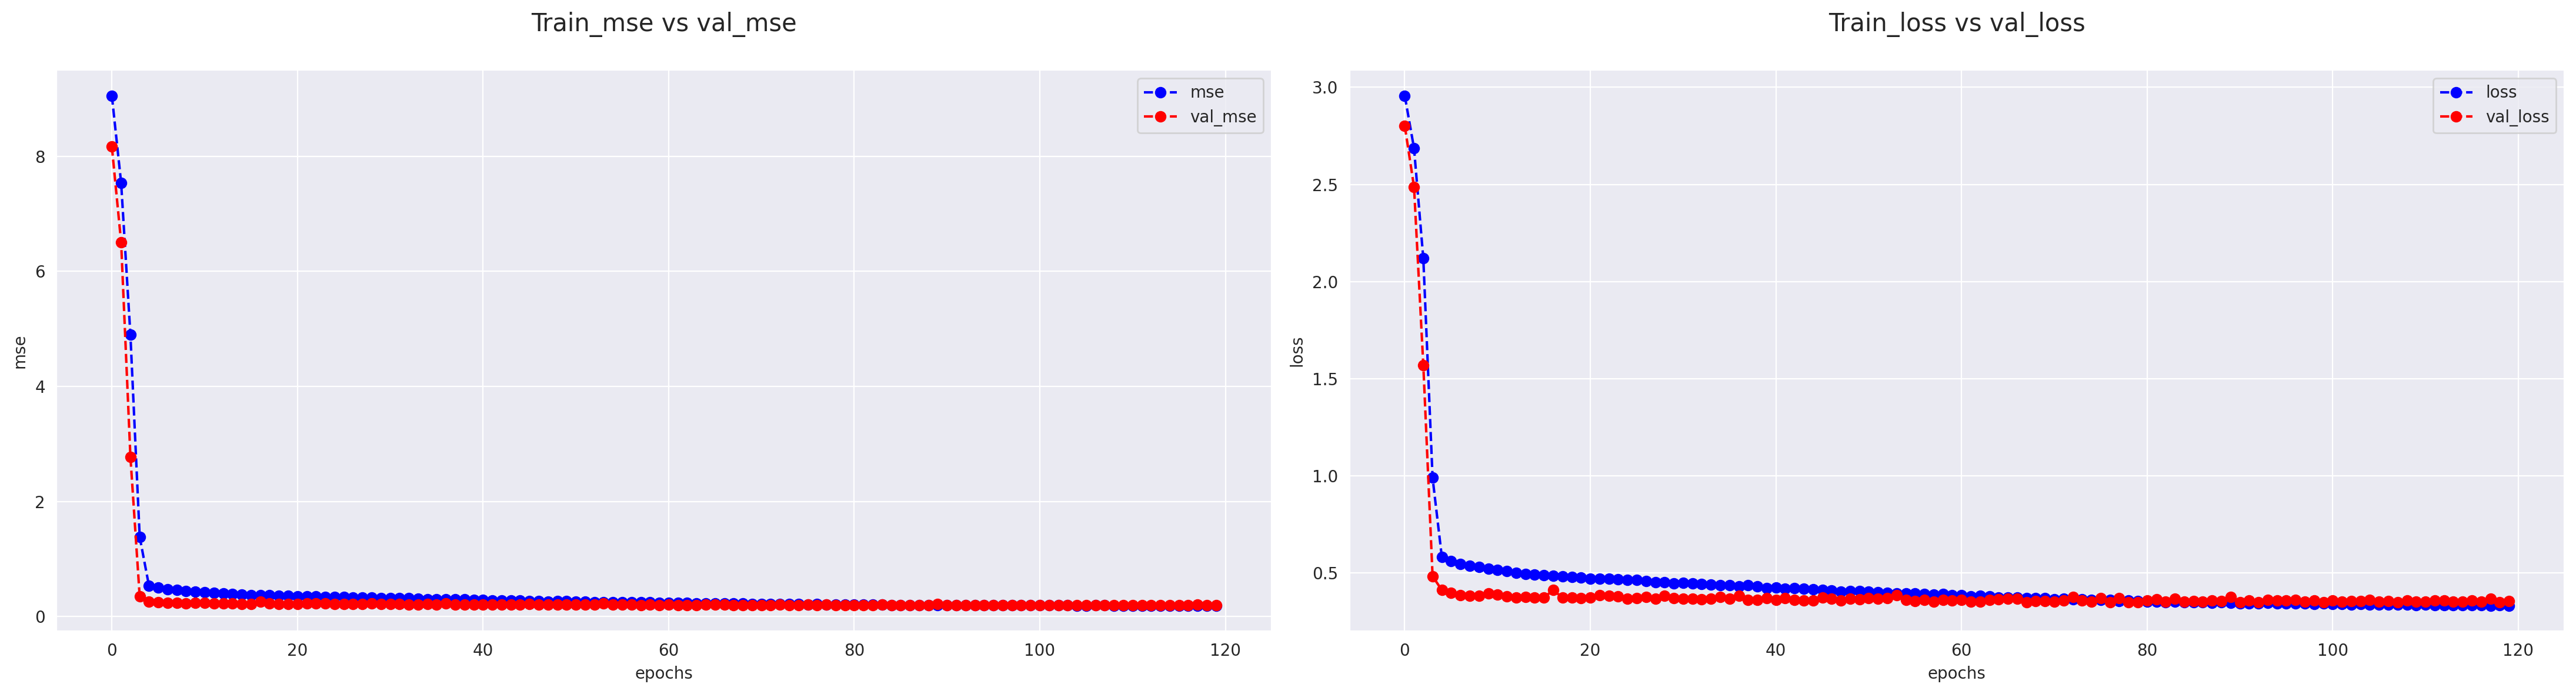

In [ ]:
plot_history_training(history.history,"mse")

In [ ]:
model.save(model_path+"note_moyenne_specs_senscritique.h5")